In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import csv

<h1>Zillow</h1>

In [3]:

#Conditions: |, #, Number, APT
#suffixes = ['AVE', 'BLVD', 'CIR', 'CT', 'DR', 'LN', 'PKWY', 'PL', 'RD', 'ST', 'WAY']

def clean_address(address):
    splitters = {'|', '#', 'APT', 'ROOM'} 
    #'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
    suffixes = {'AVE', 'BLVD', 'CIR', 'CT', 'DR', 'LN', 'PKWY', 'PL', 'RD', 'ST', 'WAY'}
    past_suffix = False

    split_address = address.split(' ')
    for i, s in enumerate(split_address):
        if s == '|':
            return ' '.join(split_address[i+1:])
        if s[0] == '#' or s in splitters:
            return ' '.join(split_address[:i])
    return address

# Test Cases
# print(clean_address('44 MOZART ST #P'))
# print(clean_address('RIDGECREST VILLAGE | 5120 WASHINGTON ST'))
# print(clean_address('720 BENNINGTON ST APT 208B'))
# print(clean_address('23 ABERDEEN ST ROOM 1-3'))
# print(clean_address('1840 COMMONWEALTH AVE'))

In [4]:
zillow = pd.read_csv('./data/all_listings.csv')

zillow = zillow[zillow['Address'].notna()]
#zillow[~zillow['Address'].str.contains('UNDISCLOSED ADDRESS')]
# zillow['Address'] = zillow['Address'].map(str)
# zillow['contains_adrs'] = zillow['Address'].str.contains('(UNDISCLOSED ADDRESS)', na=False)

zillow = zillow.drop(['Property URL', 'Country', 'Baths', 'State'], axis=1)
zillow['Address'] = zillow['Address'].str.upper()
zillow['Address'] = zillow['Address'].apply(lambda x: clean_address(x))
zillow[['Zip', 'Beds']] = zillow[['Zip', 'Beds']].astype('Int64')
zillow.head()


Property type            Address           City   Zip  Beds  \
0     Apartment       44 MOZART ST  Jamaica Plain  2130  <NA>   
1     Apartment     2 MONTFERN AVE       Brighton  <NA>     1   
2     Apartment  571 WASHINGTON ST         Boston  2111     4   
3     Apartment      314 WARREN ST        Roxbury  2119     1   
4     Apartment     23 ABERDEEN ST         Boston  2215  <NA>   

   Rental Price (USD per month)   Size Size unit Price per size unit (USD)  
0                           200    0.0      sqft                       NaN  
1                           995    NaN      sqft                       NaN  
2                          1095  100.0      sqft                     10.95  
3                          1200    0.0      sqft                       NaN  
4                          1200    0.0      sqft                       NaN

<h1>Harvard Data</h1>

In [5]:
padlong = pd.read_csv("./data/PAD.Long.2021.csv")

l = ["R1", "R2", "R3", "R4"]
padlong = padlong[padlong['FY2021.AV'].notna()]
padlong = padlong[padlong['FY2021.LU'].isin(l)]

padlong.drop(
    padlong.columns.difference(
        ['PID', 'ST_NAME', 'ST_NUM', 'ZIPCODE', 'FY2021.LU', 'FY2021.AV', 'DiffAV2021', 'X', 'Y', 
        #'CM_ID', 'Blk_ID_10' 
        ]
        ), 1, inplace=True)
padlong.rename(columns={'X': 'longitude', 'Y': 'latitude'}, inplace=True)
padlong["Address"] = padlong['ST_NUM'] + ' ' + padlong['ST_NAME']
#padlong[['X', 'Y']] = padlong[['X', 'Y']].round(5)
padlong['price_bracket'] = padlong['FY2021.AV'].apply(
    lambda x: '$1000000+' if len(str(x)) >= 9
    else '$'+str(int(round(x,-5))) + '-' + str(int(round(x,-5) + 100000)) if round(x,-5) < (round(x,-4))
    else '$'+str(int(round(x,-5) - 100000)) + '-' + str(int(round(x,-5))) if round(x,-5) > (round(x,-4)) 
    else None)


C:\Users\david\AppData\Local\Temp\ipykernel_26268\56049475.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  padlong.drop(


<h1>Boston Building Inventory Dataset</h1>

In [6]:
inventory = pd.read_csv('./data/BuildingInventory.csv')
inventory = inventory.loc[inventory['use_class'] == 'Residential']
inventory = inventory[['pid_long', 'building_subtypology', 'sqft_class', 'unit_num', 'sqft', 'owner_list', 'env_recommendation_count']]
inventory.head()
print(len(inventory.index))

C:\Users\david\AppData\Local\Temp\ipykernel_26268\2597446351.py:1: DtypeWarning: Columns (1,53) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv('./data/BuildingInventory.csv')


76993


In [7]:
all_properties = padlong.merge(inventory, left_on='PID', right_on='pid_long', how='outer')
all_properties.drop(['pid_long', 'ST_NUM', 'ST_NAME'], axis=1, inplace=True)
all_properties.drop_duplicates(inplace=True)
all_properties = all_properties[all_properties['owner_list'].notna()]
all_properties['rent_val'] = all_properties['FY2021.AV'].apply(lambda x: round(x, -4) * .01)
all_properties = all_properties[all_properties['rent_val'].notna()]
all_properties.sort_values('rent_val', ascending=False).head()
#print(len(all_properties.index))

PID  ZIPCODE FY2021.LU   FY2021.AV  DiffAV2021  longitude  \
58214  503270010   2116.0        R1  27977700.0    751000.0  -71.08037   
58167  502826000   2116.0        R1  27858100.0    732700.0  -71.07249   
58186  502896000   2116.0        R1  18030000.0    525400.0  -71.07837   
57733  501707000   2108.0        R3  17313500.0    504300.0  -71.06760   
57700  501651110   2108.0        R1  15733400.0    950200.0  -71.06846   

       latitude            Address price_bracket  \
58214  42.35083       25 EXETER ST     $1000000+   
58167  42.35391  5 COMMONWEALTH AV     $1000000+   
58186  42.35271   315 DARTMOUTH ST     $1000000+   
57733  42.35843    85 MT VERNON ST     $1000000+   
57700  42.35876    19 LOUISBURG SQ     $1000000+   

                   building_subtypology     sqft_class  unit_num     sqft  \
58214           Single-Family, Pre-1915  < 25,000 sqft       NaN  21711.0   
58167           Single-Family, Pre-1915  < 25,000 sqft       NaN  20326.0   
58186           Single-Family, Pre-1915  < 25,000 sqft       NaN  13033.0   
57733  Multi-Family (3 units), Pre-1915  < 25,000 sqft       NaN  14421.0   
57700           Single-Family, Pre-1915  < 25,000 sqft       NaN   8286.0   

                       owner_list  env_recommendation_count  rent_val  
58214                   HYER LYNN                       3.0  279800.0  
58167  FIVE COMMONWEALTH MORTGAGE                       3.0  278600.0  
58186            CASHMAN JAY M TS                       3.0  180300.0  
57733     HEILBRONNER WARREN M TS                       3.0  173100.0  
57700               SMITH LINDA K                       3.0  157300.0

In [8]:
rent_by_landlord = all_properties
rent_by_landlord = rent_by_landlord[['owner_list', 'rent_val']]

temp = rent_by_landlord['owner_list']
temp = temp.value_counts().to_frame().reset_index()
temp.rename(columns={'index': 'owner_list', 'owner_list': 'property_count'}, inplace=True)

rent_by_landlord['total_possible_income'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform('sum')
rent_by_landlord['average_rent_price'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform(np.mean)
rent_by_landlord = rent_by_landlord[['owner_list', 'total_possible_income', 'average_rent_price']]
rent_by_landlord = rent_by_landlord.drop_duplicates(['owner_list', 'total_possible_income', 'average_rent_price'])

rent_by_landlord = rent_by_landlord.merge(temp, on="owner_list")
rent_by_landlord.sort_values(by='total_possible_income', ascending=False).head()
#temp.head()



C:\Users\david\AppData\Local\Temp\ipykernel_26268\330453856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_by_landlord['total_possible_income'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform('sum')
C:\Users\david\AppData\Local\Temp\ipykernel_26268\330453856.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_by_landlord['average_rent_price'] = rent_by_landlord.groupby('owner_list')['rent_val'].transform(np.mean)


owner_list  total_possible_income  \
40585  BEACON COURT COOPERATIVE INC               358100.0   
40527                     HYER LYNN               279800.0   
40499    FIVE COMMONWEALTH MORTGAGE               278600.0   
3646              TS LAND TRUST LLC               202500.0   
40512              CASHMAN JAY M TS               180300.0   

       average_rent_price  property_count  
40585        89525.000000               4  
40527       279800.000000               1  
40499       278600.000000               1  
3646          7232.142857              28  
40512       180300.000000               1

<h1>RentSmart Data</h1>

In [9]:
rentsmart = pd.read_csv('./data/RentSmart-Data.csv')
rentsmart = rentsmart[rentsmart['violation_type'] != 'Enforcement Violations']
rentsmart['address'] = rentsmart['address'].apply(lambda x: x.split(',')[0].upper())
rentsmart = rentsmart.drop(['parcel', 'year built', 'year remodeled', 'property_type'], axis=1)
rentsmart.head()


date       violation_type          description  \
59   2022-10-26 23:44:54.85  Sanitation Requests   Abandoned Vehicles   
60   2022-10-26 23:15:52.05  Sanitation Requests      Rodent Activity   
61   2022-10-26 22:58:03.23  Sanitation Requests      Rodent Activity   
62   2022-10-26 22:40:33.91  Sanitation Requests      Rodent Activity   
63  2022-10-26 20:09:18.543  Sanitation Requests  Empty Litter Basket   

            address neighborhood  zip_code  \
59         437 D ST       Boston      2210   
60  21 WORCESTER SQ      Roxbury      2118   
61    9 STILLMAN ST       Boston      2113   
62      76 SALEM ST       Boston      2113   
63   108 CHARLES ST       Boston      2114   

                                 owner   latitude  longitude  
59  FOUR 37 D STREET CONDOMINIUM TRUST  42.345160 -71.042990  
60           SEVENTEEN-21 WORCESTER SQ  42.336370 -71.074800  
61                        DEROSA LUCIA  42.363800 -71.056210  
62               DAMORE PROPERTIES LLC  42.363590 -71.056030  
63         ONE 06-108 CHARLES ST CD TR  42.358895 -71.070901

<h1>2022 Violations</h1>

In [10]:
def merge_address(st_no, st_high, street, suffix):
    if st_high != np.NaN:
        return str(st_no) + '-' + str(st_high) + ' ' + str(street).upper() + ' ' + str(suffix)
    else:
        return str(st_no) + ' ' + str(street).upper() + ' ' + str(suffix) 

In [11]:
reg_violation = pd.read_csv("./data/Violations2010_2021.csv", encoding='cp1252')
reg_violation.drop(
    reg_violation.columns.difference(
        ['ticket_no', 'status_dttm', 'status', 'code', 'description', 'value', 'stno', 'sthigh', 'street', 'suffix', 'zip', 'city', 
        'latitude', 'longitude', 'Land_Parcel_ID', 'Blk_ID_10', 'PropViol', 'CodeViol' ]
        ),
    1, inplace=True)

reg_violation['zip'] = reg_violation['zip'].fillna(0)
reg_violation['zip'] = reg_violation['zip'].astype(int)
reg_violation['Address'] = reg_violation.apply(lambda x: 
    merge_address(x['stno'], x['sthigh'], x['street'], x['suffix']),axis=1
)
reg_violation['Address_list'] = reg_violation['Address'].apply(lambda x: x.split('-nan'))
reg_violation['Address'] = reg_violation['Address_list'].apply(lambda x: ''.join(x))
reg_violation.drop(['stno', 'sthigh', 'street', 'suffix', 'Land_Parcel_ID', 'Blk_ID_10', 'Address_list'], axis=1, inplace=True)
reg_violation.sort_values(by="value", ascending=False).head()

C:\Users\david\AppData\Local\Temp\ipykernel_26268\2709745314.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  reg_violation.drop(


ticket_no          status_dttm  status code    value  \
147203  CE129771  2012-07-19 11:07:00  Closed  14b  10000.0   
132948  CE114037  2011-12-16 09:45:00  Closed  14a   3000.0   
234508  CE163356  2013-08-23 02:45:00  Closed  14a   3000.0   
14144    CE86657  2010-11-15 12:51:00  Closed   13   3000.0   
481399  CE383454  2018-02-12 10:40:00  Closed  14a   3000.0   

                        description        city   zip  PropViol  CodeViol  \
147203    Illegal dumping  vehicle:    Mattapan  2126         0         1   
132948  Illegal dumping w a vehicle  Dorchester  2125         0         1   
234508  Illegal dumping w a vehicle  Dorchester  2122         0         1   
14144    Illegal dumping: Haz Waste  Dorchester  2122         0         1   
481399  Illegal dumping w a vehicle  Roslindale  2131         0         1   

        latitude  longitude                  Address  
147203  42.27986  -71.09187             18 EVELYN ST  
132948  42.31797  -71.06662        744-748 DUDLEY ST  
234508  42.29199  -71.06111               15 KING ST  
14144   42.28869  -71.05440       456-458 ASHMONT ST  
481399  42.27499  -71.11478  950 AMERICAN LEGION HWY

In [12]:
property_cities = reg_violation.merge(all_properties, on='Address')
property_cities.drop(['ticket_no', 'latitude_y', 'longitude_y', 'ZIPCODE', 'sqft_class', 'sqft', 'unit_num', 'building_subtypology', ], axis=1, inplace=True)
property_cities.head()


status_dttm  status   code  value                     description  \
0  2019-12-04 10:35:31    Open  116.1    NaN            Unsafe and Dangerous   
1  2020-01-14 09:18:00    Open     9a  250.0    Illegal dumping < 1 cubic yd   
2  2020-02-03 09:24:00    Open    22b  300.0  Unregistered motor vehicles- 2   
3  2018-09-24 09:43:47  Closed  116.2    NaN            Unsafe and Dangerous   
4  2013-04-11 13:26:07  Closed  116.2    NaN            Unsafe and Dangerous   

         city   zip  PropViol  CodeViol  latitude_x  longitude_x      Address  \
0  Dorchester  2124         1         0    42.29704    -71.08625  15 ABBOT ST   
1  Dorchester  2124         0         1    42.29704    -71.08625  15 ABBOT ST   
2  Dorchester  2124         0         1    42.29704    -71.08625  15 ABBOT ST   
3  Dorchester  2124         1         0    42.29704    -71.08625  15 ABBOT ST   
4  Dorchester  2124         1         0    42.29704    -71.08625  15 ABBOT ST   

          PID FY2021.LU  FY2021.AV  DiffAV2021    price_bracket  \
0  1401970000        R3   913100.0    274900.0  $900000-1000000   
1  1401970000        R3   913100.0    274900.0  $900000-1000000   
2  1401970000        R3   913100.0    274900.0  $900000-1000000   
3  1401970000        R3   913100.0    274900.0  $900000-1000000   
4  1401970000        R3   913100.0    274900.0  $900000-1000000   

       owner_list  env_recommendation_count  rent_val  
0  FOY ALDEXTER L                       4.0    9100.0  
1  FOY ALDEXTER L                       4.0    9100.0  
2  FOY ALDEXTER L                       4.0    9100.0  
3  FOY ALDEXTER L                       4.0    9100.0  
4  FOY ALDEXTER L                       4.0    9100.0

In [13]:
violatoins_by_city = property_cities
violatoins_by_city['city_violation_count'] = violatoins_by_city.groupby('city').city.transform('count')
violatoins_by_city['total_fines'] = violatoins_by_city.groupby('city').value.transform('sum')
get_citylandlords = violatoins_by_city[['city', 'owner_list']]
get_citylandlords = get_citylandlords.drop_duplicates()
get_citylandlords['num_landlords'] = get_citylandlords.groupby('city').city.transform('count')
violatoins_by_city = violatoins_by_city.merge(get_citylandlords, left_on=['city', 'owner_list'], right_on=['city', 'owner_list'])

violatoins_by_city.sort_values(by='status_dttm').head()

status_dttm  status code  value  \
112763  2010-01-03 11:46:00  Closed    1   25.0   
97113   2010-01-04 11:56:00  Closed    1   25.0   
130079  2010-01-04 14:06:00  Closed  17a   50.0   
130044  2010-01-04 14:10:00  Closed  15a   50.0   
130034  2010-01-04 14:11:00  Closed  17a   50.0   

                          description          city   zip  PropViol  CodeViol  \
112763    Improper storage trash: res  Mission Hill  2120         0         1   
97113     Improper storage trash: res  South Boston  2127         0         1   
130079  Failure clear sidewalk - snow      Brighton  2135         0         1   
130044      Removal snow private prop      Brighton  2135         0         1   
130034  Failure clear sidewalk - snow      Brighton  2135         0         1   

        latitude_x  ...  FY2021.LU  FY2021.AV DiffAV2021 price_bracket  \
112763    42.33142  ...         R3  1837700.0  -171200.0     $1000000+   
97113     42.33370  ...         R3  1669700.0   263300.0     $1000000+   
130079    42.34876  ...         R3  1380400.0   166300.0     $1000000+   
130044    42.34875  ...         R3  1831800.0   384600.0     $1000000+   
130034    42.34872  ...         R3  1138700.0   124100.0     $1000000+   

                        owner_list  env_recommendation_count rent_val  \
112763                XU XIAOQIANG                       3.0  18400.0   
97113               CANAVAN THOMAS                       3.0  16700.0   
130079  ZAIMIS FAMILY REALTY TRUST                       3.0  13800.0   
130044             18 EGLESTON LLC                       2.0  18300.0   
130034              LANE MATTHEW E                       3.0  11400.0   

       city_violation_count  total_fines  num_landlords  
112763                 6778     314465.0            335  
97113                  4662     248610.0            796  
130079                 8579     451555.0           1143  
130044                 8579     451555.0           1143  
130034                 8579     451555.0           1143  

[5 rows x 23 columns]

In [14]:
normalized_df = violatoins_by_city
normalized_df = normalized_df[['city', 'city_violation_count', 'total_fines']]
normalized_df.drop_duplicates(inplace=True)
normalized_df['city_violation_count'] = normalized_df['city_violation_count'].apply(lambda x: (x - normalized_df['city_violation_count'].mean()) / normalized_df['city_violation_count'].std())
normalized_df['total_fines'] = normalized_df['total_fines'].apply(lambda x: (x - normalized_df['total_fines'].mean()) / normalized_df['total_fines'].std())
normalized_df.head()

C:\Users\david\AppData\Local\Temp\ipykernel_26268\3937263995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df.drop_duplicates(inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_26268\3937263995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df['city_violation_count'] = normalized_df['city_violation_count'].apply(lambda x: (x - normalized_df['city_violation_count'].mean()) / normalized_df['city_violation_count'].std())
C:\Users\david\AppData\Local\Temp\ipykernel_26268\3937263995.py:5: SettingWithCopyWarning: 
A value is tryi

city  city_violation_count  total_fines
0      Dorchester              3.441204     3.563508
350      Brighton              0.031339     0.054247
372  West Roxbury             -0.569557    -0.515872
484  South Boston             -0.359383    -0.316833
486        Boston              0.537173     0.092800

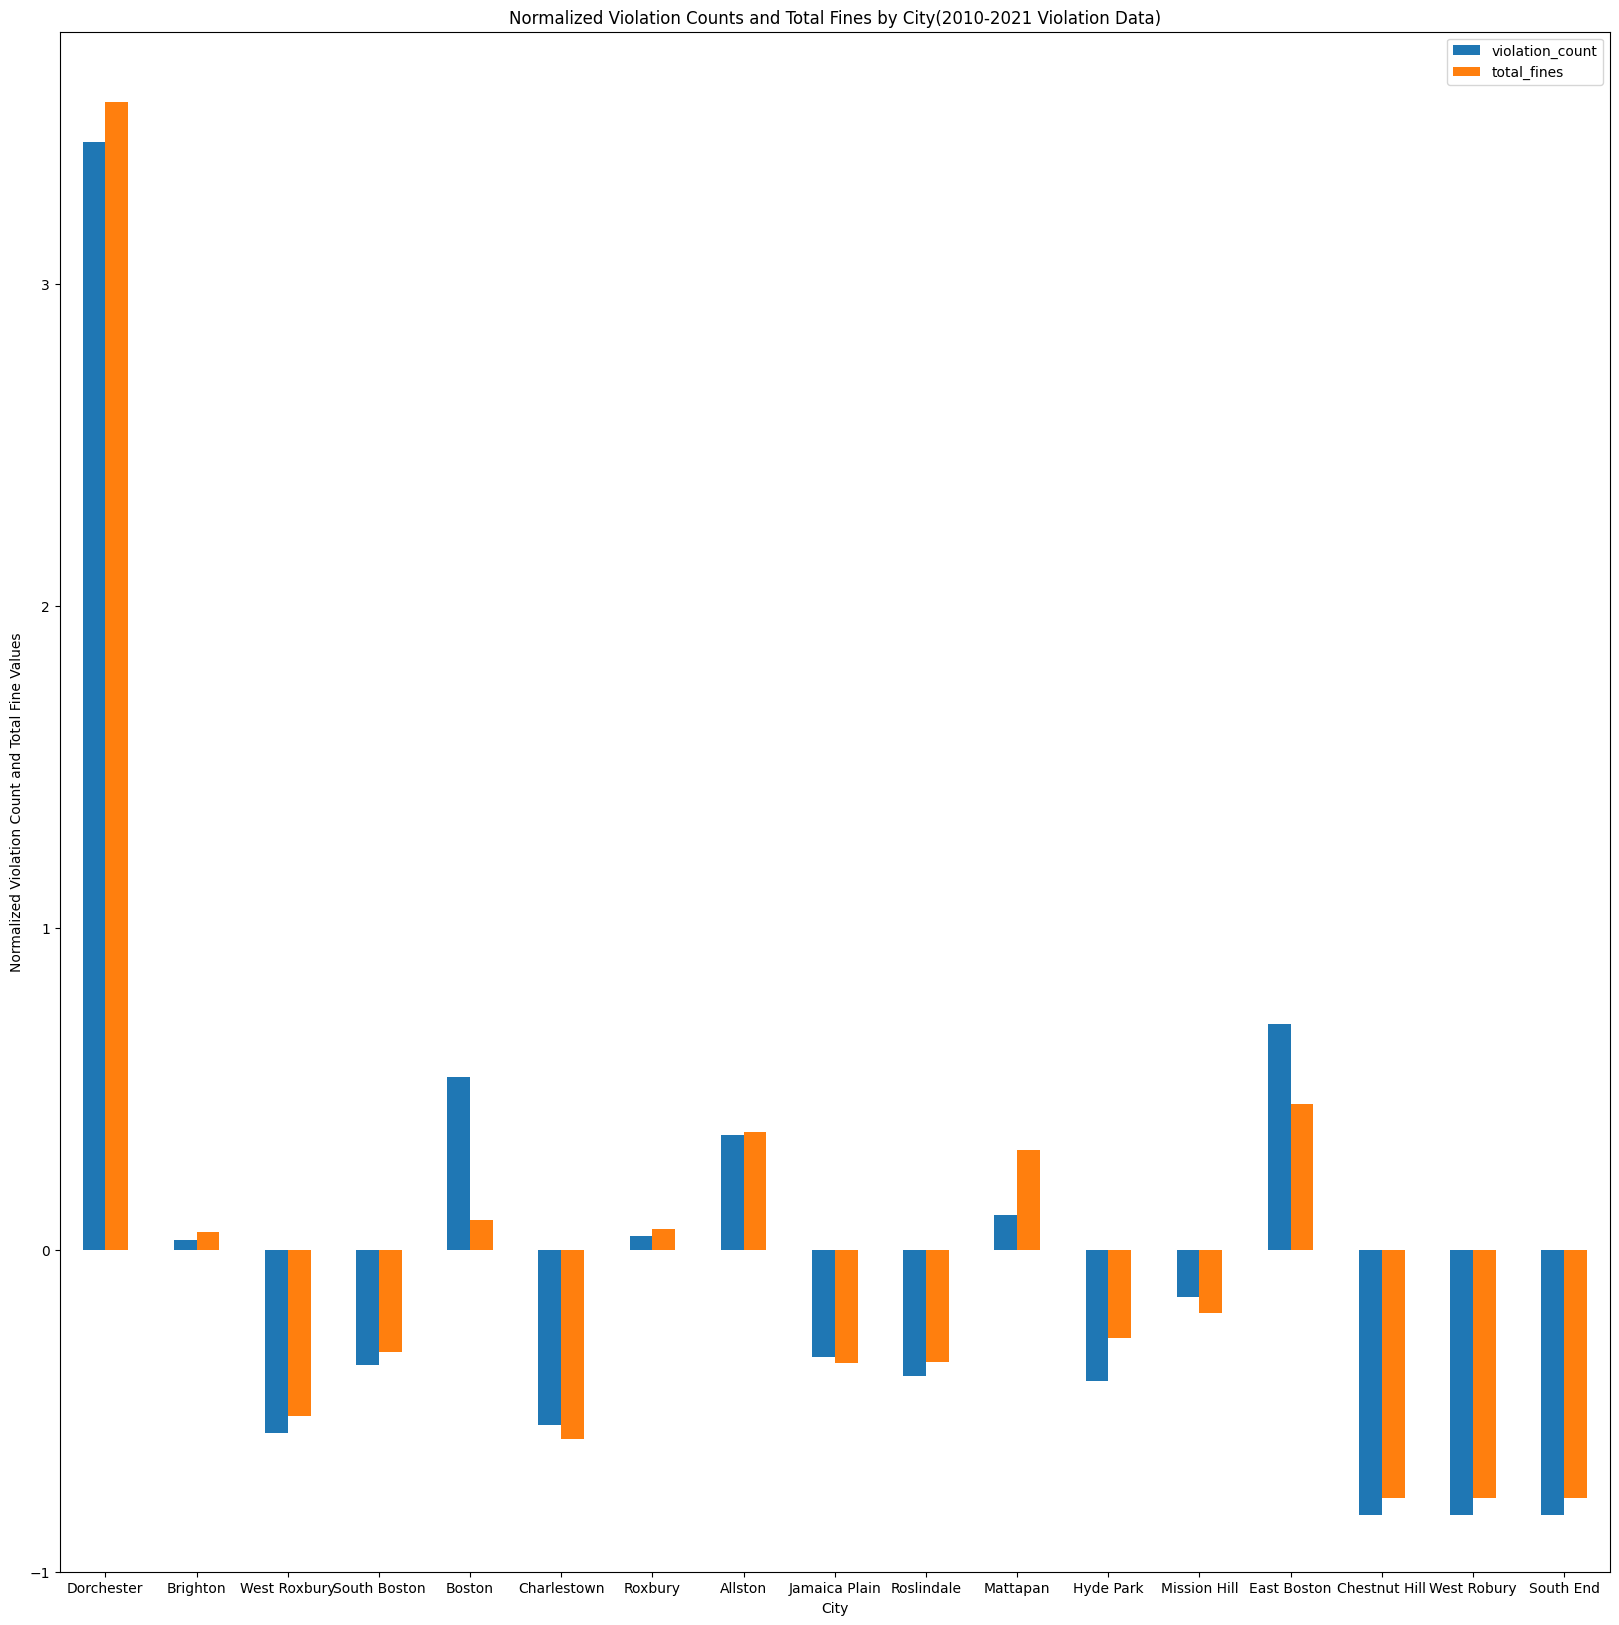

In [15]:
city = normalized_df['city'].tolist()
violation_count = normalized_df['city_violation_count'].tolist()
total_fines = normalized_df['total_fines'].tolist()
df = pd.DataFrame({'violation_count': violation_count,
                   'total_fines': total_fines}, index=city)
ax = df.plot.bar(rot=0, ylim=-1, xlim=4, figsize=(20, 20), 
xlabel='City', ylabel='Normalized Violation Count and Total Fine Values', title='Normalized Violation Counts and Total Fines by City(2010-2021 Violation Data)')

In [16]:
heat_df = violatoins_by_city[['latitude_x', 'longitude_x', 'value',]]
heat_df = heat_df[heat_df['value'].notna()]
#heat_df.head()
heat_df['value'] = (heat_df['value']- heat_df['value'].mean()) / heat_df['value'].std()

boston_map = folium.Map(location=[42.3601, -71.0589])
heat_data = heat_df.values.tolist()
HeatMap(heat_data).add_to(boston_map)
boston_map


In [31]:
all_with_zillow = violatoins_by_city.merge(zillow, on='Address', how='left')
all_with_zillow.drop(['City', 'Zip', 'Beds', 'Size', 'Size unit', 'Price per size unit (USD)'], axis=1, inplace=True)
is_zillow = all_with_zillow[all_with_zillow['Property type'].notna()]
is_zillow['num_listings'] = is_zillow.groupby('city').city.transform('count')
is_zillow = is_zillow[['city', 'num_listings']]
is_zillow.drop_duplicates(inplace=True)
all_with_zillow = all_with_zillow.merge(is_zillow, on='city')
all_with_zillow.head()

C:\Users\david\AppData\Local\Temp\ipykernel_26268\3641474546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_zillow['num_listings'] = is_zillow.groupby('city').city.transform('count')
C:\Users\david\AppData\Local\Temp\ipykernel_26268\3641474546.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_zillow.drop_duplicates(inplace=True)


status_dttm  status   code  value                     description  \
0  2019-12-04 10:35:31    Open  116.1    NaN            Unsafe and Dangerous   
1  2020-01-14 09:18:00    Open     9a  250.0    Illegal dumping < 1 cubic yd   
2  2020-02-03 09:24:00    Open    22b  300.0  Unregistered motor vehicles- 2   
3  2018-09-24 09:43:47  Closed  116.2    NaN            Unsafe and Dangerous   
4  2013-04-11 13:26:07  Closed  116.2    NaN            Unsafe and Dangerous   

         city   zip  PropViol  CodeViol  latitude_x  ...    price_bracket  \
0  Dorchester  2124         1         0    42.29704  ...  $900000-1000000   
1  Dorchester  2124         0         1    42.29704  ...  $900000-1000000   
2  Dorchester  2124         0         1    42.29704  ...  $900000-1000000   
3  Dorchester  2124         1         0    42.29704  ...  $900000-1000000   
4  Dorchester  2124         1         0    42.29704  ...  $900000-1000000   

       owner_list env_recommendation_count rent_val  city_violation_count  \
0  FOY ALDEXTER L                      4.0   9100.0                 42763   
1  FOY ALDEXTER L                      4.0   9100.0                 42763   
2  FOY ALDEXTER L                      4.0   9100.0                 42763   
3  FOY ALDEXTER L                      4.0   9100.0                 42763   
4  FOY ALDEXTER L                      4.0   9100.0                 42763   

   total_fines num_landlords Property type  Rental Price (USD per month)  \
0    2370785.0          5260           NaN                           NaN   
1    2370785.0          5260           NaN                           NaN   
2    2370785.0          5260           NaN                           NaN   
3    2370785.0          5260           NaN                           NaN   
4    2370785.0          5260           NaN                           NaN   

   num_listings  
0           526  
1           526  
2           526  
3           526  
4           526  

[5 rows x 26 columns]

In [43]:
normalized_listings = all_with_zillow
normalized_listings = all_with_zillow[['city', 'city_violation_count', 'num_listings']].drop_duplicates()
normalized_listings['city_violation_count'] = normalized_listings['city_violation_count'].apply(lambda x: (x - normalized_listings['city_violation_count'].mean()) / normalized_listings['city_violation_count'].std())
normalized_listings['num_listings'] = normalized_listings['num_listings'].apply(lambda x: (x - normalized_listings['num_listings'].mean()) / normalized_listings['num_listings'].std())
normalized_listings.head()


city  city_violation_count  num_listings
0        Dorchester              3.200084      0.246283
42807      Brighton             -0.142197      0.053379
51514  West Roxbury             -0.731183     -0.604767
54069  South Boston             -0.525175     -0.434557
58733        Boston              0.353611     -0.090894

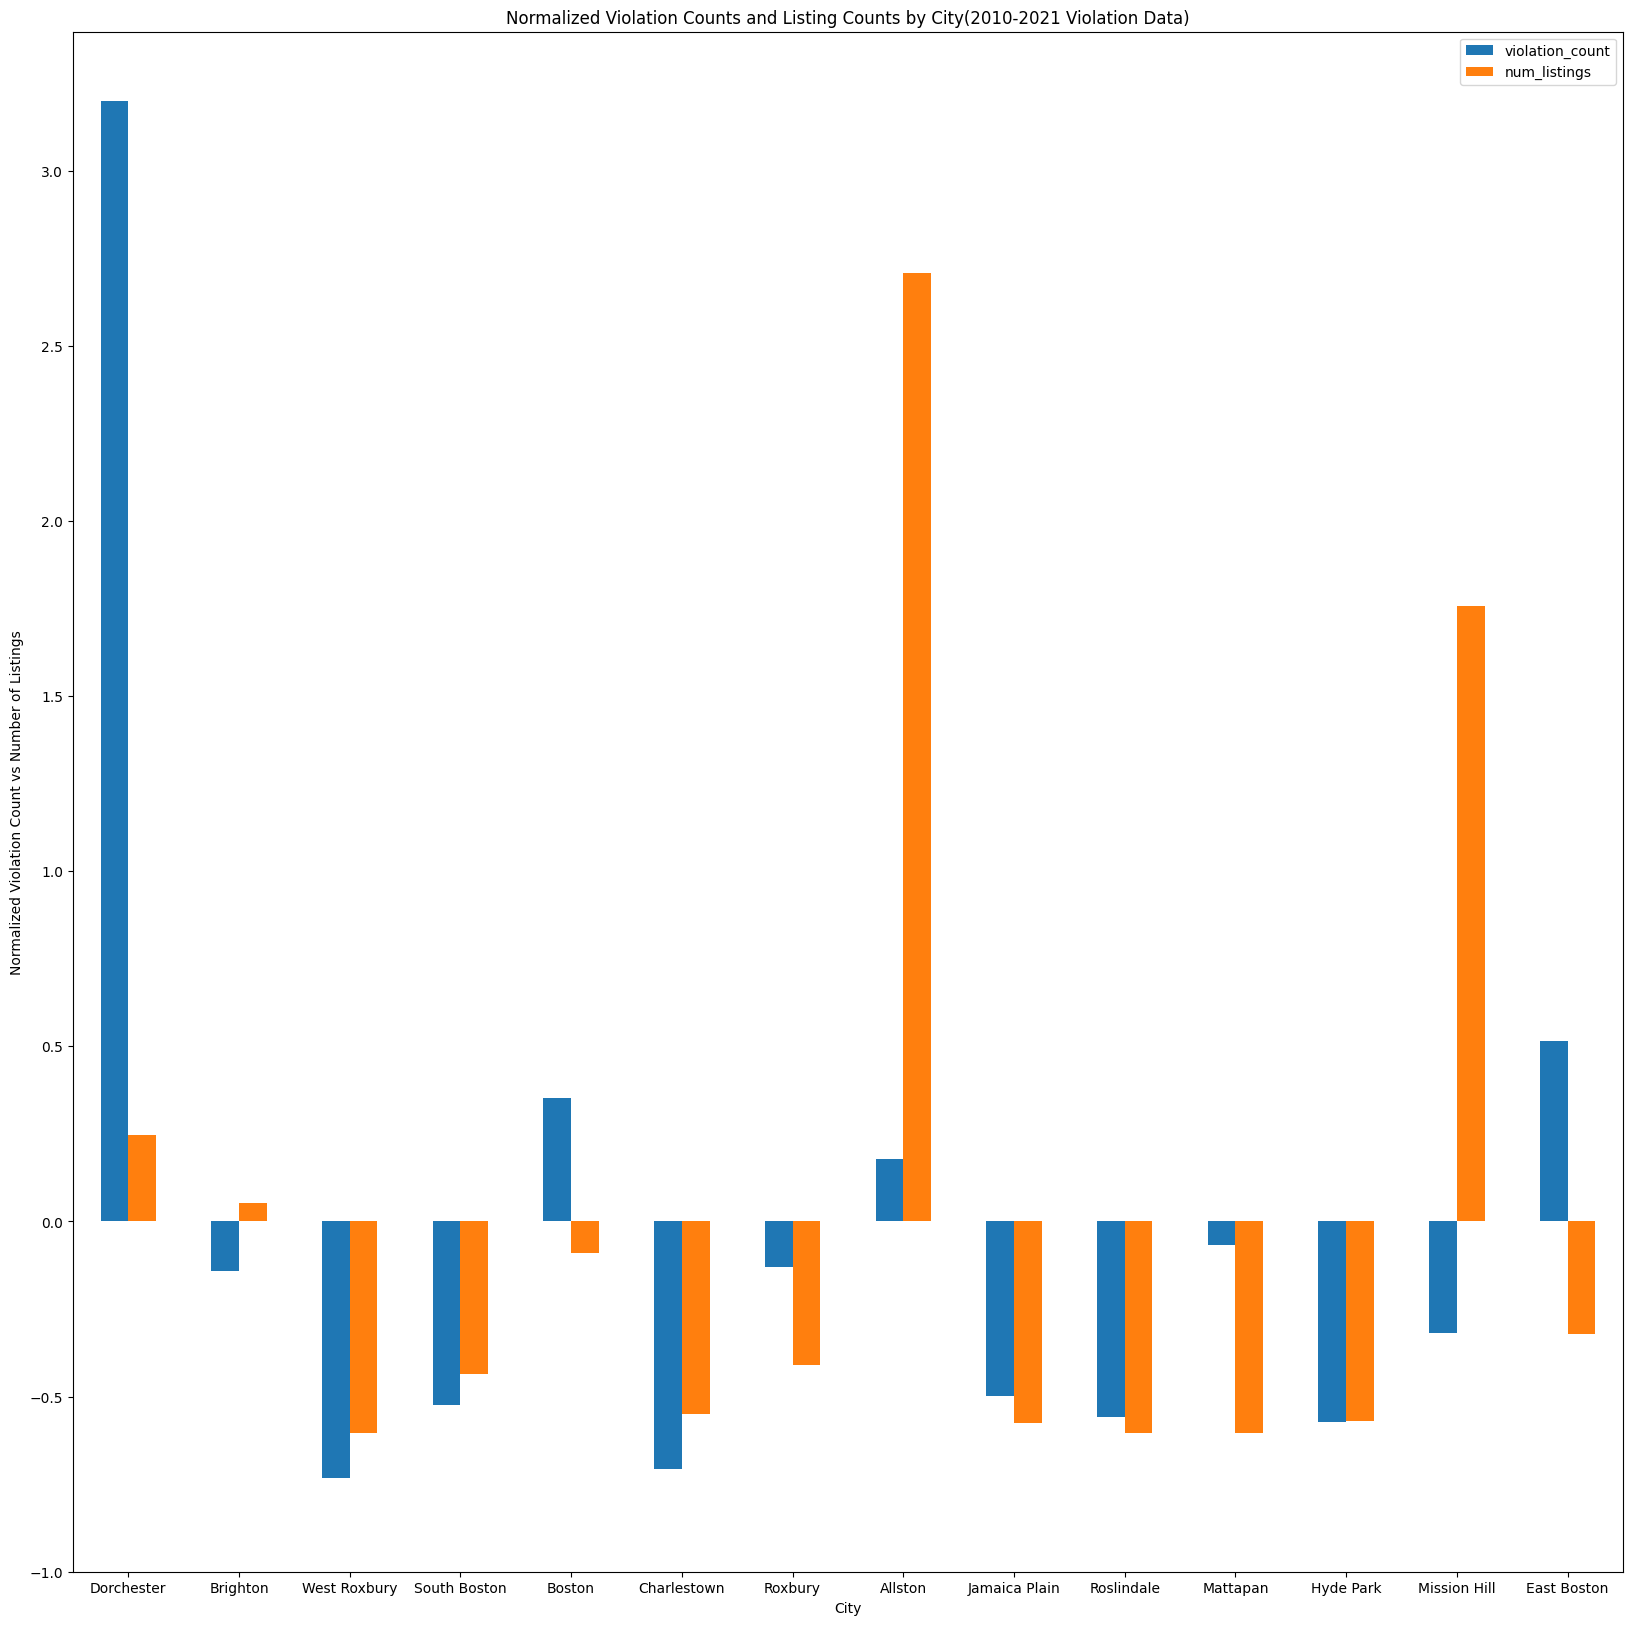

In [44]:
city = normalized_listings['city'].tolist()
violation_count = normalized_listings['city_violation_count'].tolist()
num_listings = normalized_listings['num_listings'].tolist()
df = pd.DataFrame({'violation_count': violation_count,
                   'num_listings': num_listings}, index=city)
ax = df.plot.bar(rot=0, ylim=-1, xlim=4, figsize=(20, 20), 
xlabel='City', ylabel='Normalized Violation Count vs Number of Listings', title='Normalized Violation Counts and Listing Counts by City(2010-2021 Violation Data)')